In [1]:
# !pip install -q --user albumentations
# !pip3 install pydicom

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os
import torch.optim as optim
import time
import ipywidgets as widgets
import pickle


# 導入dicom套件
from pydicom import dcmread
from pydicom.data import get_testdata_files

In [4]:
from utils.dataset import getAllDataPath, CustomImageDataset, show_image
from utils.unet import UNet, ResUnet, AttUnet
from utils.loss import DiceLoss, FocalLoss

In [5]:
BATCH_SIZE = 8
WIDTH = 256
HEIGHT = 256
device = 'cuda:0'

In [6]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

transform = A.Compose([
    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([                       
    A.Resize(WIDTH, HEIGHT),
])

## 資料整理與處理

In [7]:
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/CT/'
CT_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_Label/'
MRI_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_nonLabel/'
MRI_nlb_data = getAllDataPath(root, test_split_size=None, imgOnly=True)

for data in ['CT_data', 'MRI_data', 'MRI_nlb_data']:
    i = eval(data)
    for k in i.keys():
        print(data,k, np.shape(i[k]))


dataset_train = CustomImageDataset(MRI_data['train'], transform=transform, pseudo_label=False)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

dataset_test = CustomImageDataset(MRI_data['test'], transform=target_transform, pseudo_label=False) 
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

dataset_nlb_train = CustomImageDataset(MRI_nlb_data['train'], transform=transform, pseudo_label=False)
dataloader_nlb_train = torch.utils.data.DataLoader(dataset_nlb_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

CT_dataset_train = CustomImageDataset(CT_data['train'], transform=transform, pseudo_label=False)
CT_dataloader_train = torch.utils.data.DataLoader(CT_dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

CT_dataset_test = CustomImageDataset(CT_data['test'], transform=target_transform)
CT_dataloader_test = torch.utils.data.DataLoader(CT_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

CT_data train (2299, 2)
CT_data test (575, 2)
MRI_data train (49, 2)
MRI_data test (13, 2)
MRI_nlb_data train (401,)


torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([34354,   733,   576,   720, 27788,   627,   611,    60,    43,
          24]), array([0.        , 0.09983001, 0.19966002, 0.29949003, 0.39932004,
       0.49915004, 0.59898007, 0.69881004, 0.7986401 , 0.89847004,
       0.9983001 ], dtype=float32)) tensor([0.])


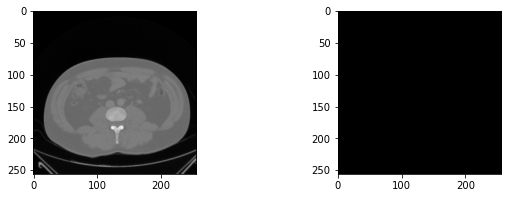

In [8]:
'''
Abs: test transform on dataloader_train.
---
take first image in every batch.
'''
for data in CT_dataloader_train:
    for x, y in zip(*data): 
        print(x.shape, y.shape)
        print(np.histogram(x.numpy()), y.unique())
    
        show_image(x.squeeze(0).numpy(), y.squeeze(0).numpy())
        break
    break

## 進行最佳化器與模型設計
- 最佳化器(預設使用BECLossWithLogit)
- 模型(並將模型放到torch指定的運算空間: [cpu, cuda])

>二元分類，只有一個channel的輸出的場合。

In [9]:
import torch
import torch.nn as nn
 
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
 
    def	forward(self, input, target):
        N = target.size(0)
        smooth = 1
 
        input_flat = input.view(N, -1)
        target_flat = target.view(N, -1)
 
        intersection = input_flat * target_flat
 
        loss = (2 * intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
        loss = 1 - loss.sum() / N
 
        return loss


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    r"""
        This criterion is a implemenation of Focal Loss, which is proposed in 
        Focal Loss for Dense Object Detection.

            Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])

        The losses are averaged across observations for each minibatch.

        Args:
            alpha(1D Tensor, Variable) : the scalar factor for this criterion
            gamma(float, double) : gamma > 0; reduces the relative loss for well-classiﬁed examples (p > .5), 
                                   putting more focus on hard, misclassiﬁed examples
            size_average(bool): By default, the losses are averaged over observations for each minibatch.
                                However, if the field size_average is set to False, the losses are
                                instead summed for each minibatch.


    """
    def __init__(self, class_num, alpha=None, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = Variable(torch.ones(class_num, 1))
        else:
            if isinstance(alpha, Variable):
                self.alpha = alpha
            else:
                self.alpha = Variable(alpha)
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average

    def forward(self, inputs, targets):
        N = inputs.size(0)
        C = inputs.size(1)
        P = F.softmax(inputs)

        class_mask = inputs.data.new(N, C).fill_(0)
        class_mask = Variable(class_mask)
        ids = targets.view(-1, 1)
        class_mask.scatter_(1, ids.data, 1.)
        #print(class_mask)


        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()
        alpha = self.alpha[ids.data.view(-1)]

        probs = (P*class_mask).sum(1).view(-1,1)

        log_p = probs.log()
        #print('probs size= {}'.format(probs.size()))
        #print(probs)

        batch_loss = -alpha*(torch.pow((1-probs), self.gamma))*log_p 
        #print('-----bacth_loss------')
        #print(batch_loss)


        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        return loss

In [11]:
class BCEWithRCFLoss(nn.Module):
    '''
    red: https://github.com/meteorshowers/RCF-pytorch/blob/master/functions.py
    '''
    def __init__(self):
        super(BCEWithRCFLoss, self).__init__()
  
    def	forward(self, input, target):
        target = target.long()
        num_positive = torch.sum((mask==1)).float()
        num_negative = torch.sum((mask==0)).float()

        mask[mask == 1] = 1.0 * num_negative / (num_positive + num_negative)
        mask[mask == 0] = 1.1 * num_positive / (num_positive + num_negative)
        cost = torch.nn.functional.binary_cross_entropy_with_logits(
                input.float(),target.float(), weight=mask, reduce=False)
        return torch.sum(cost)

## 訓練模型 DANN+Unet

In [12]:
# from unet import convBlock, Encoder, UpSampleConvs, Decoder
# from unet import Encoder
# from unet import Decoder
from torch.nn import functional as F

In [13]:
## 加入instance normalization
class convBlock(nn.Module):
    def __init__(self, in_ch, out_ch, padding = 'same', kernel_size=3):
        super().__init__()
        kernel_size = kernel_size
        pad_size = lambda kernel_size:(kernel_size-1)//2
        if padding=='same':
            self.padding = pad_size(kernel_size)
        else:
            self.padding = padding
        
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size, padding=self.padding, bias=False)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size, padding=self.padding, bias=False)
        self.INorm = torch.nn.InstanceNorm2d(out_ch, affine=True)
        self.BN = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
#         x = self.INorm(self.conv1(x))
        x = self.BN(self.conv1(x))
        x = self.relu(x)
#         x = self.INorm(self.conv2(x))
        x = self.BN(self.conv2(x))
        x = self.relu(x)
        return x
    
class Encoder(nn.Module):
    def __init__(self, chs=(3,32,64,128,256,512), padding='same'):
        super().__init__()
        self.FPN_enc_ftrs = nn.ModuleList([convBlock(chs[i], chs[i+1], padding) for i in range(len(chs)-1)])
        self.pool = torch.max_pool2d
        
    def forward(self, x):
        features = []
        
        for block in self.FPN_enc_ftrs:
            x = block(x)
            features.append(x)
            x = self.pool(x, kernel_size=2)
        return features

In [14]:
import torchvision
class UpSampleConvs(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.relu  = nn.ReLU()
        self.upSample = nn.Upsample(scale_factor=2)
        self.INorm = torch.nn.InstanceNorm2d(out_ch)

    def forward(self, x):
        x = self.upSample(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.INorm(x)
        return x

class Decoder(nn.Module):
    def __init__(self, chs=(512, 256, 128, 64, 32), padding='same', multi_level = 0):
        super().__init__()

        self.chs = chs
        self.padding = padding
        self.upconvs = nn.ModuleList([UpSampleConvs(chs[i], chs[i+1]) for i in range(len(chs)-1)]) # 上採樣後卷積
        self.FPN_dec_ftrs = nn.ModuleList([convBlock(chs[i], chs[i+1], padding=padding) for i in range(len(chs)-1)]) 
        self.multi_level = multi_level # int like
  
        
    def forward(self, x, encoder_features):
#         print(len(encoder_features))
        if self.multi_level == 0:
            multi_level_Ftrs = []
        elif self.multi_level == -1:
            multi_level_Ftrs = [0]*(len(encoder_features)+1)
            multi_level_Ftrs[0] = x
        else:
            multi_level_Ftrs = [0]*(self.multi_level+1)
            multi_level_Ftrs[0] = x
            
        for i in range(len(self.chs)-1):
            enc_ftrs = encoder_features[i]

            x = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.FPN_dec_ftrs[i](x)
            if self.multi_level == 0:
                pass
            elif i<len(multi_level_Ftrs)-1:
                multi_level_Ftrs[i+1] = x

        return x, multi_level_Ftrs
    
    def crop(self, enc_ftrs, x):

        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

### 調整unet ch數

In [15]:
SCALE=4

In [16]:
class FeatureExtractor(nn.Module):
    def __init__(self, enc_chs=(1,64,128,256,512,1024), padding='same'):
        super().__init__()
        tmp = enc_chs[0]
        enc_chs = [i//SCALE for i in enc_chs]
        enc_chs[0]=tmp
        enc_chs = tuple(enc_chs)
        self.BN0       = nn.BatchNorm2d(enc_chs[0])
        self.encoder     = Encoder(enc_chs, padding=padding)

    def forward(self, x):
        x = self.BN0(x)
        enc_ftrs = self.encoder(x)
        return enc_ftrs

class LabelPredictor(nn.Module):
    def __init__(self, out_sz, num_class=1, retain_dim=False, padding='same',
                         activation=None, dec_chs=(1024, 512, 256, 128, 64), multi_level=0):
        super().__init__()
        dec_chs = tuple(i//SCALE for i in dec_chs)
        self.head  = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz = out_sz
        self.activation = activation
        self.decoder     = Decoder(dec_chs, multi_level=multi_level, padding=padding)
        self.multi_level = multi_level
        
    def forward(self, enc_ftrs):
        
        out, multi_level_Ftrs  = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:]) # 把不同尺度的所有featuremap都輸入decoder，我們在decoder需要做featuremap的拼接
        out = self.head(out)
        if self.activation:
            out = self.activation(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
            
        if self.multi_level == 0:
            return out, []
        else:  
            return out, multi_level_Ftrs


class conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super().__init__()
        self.cell=nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, 1, 1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
    def forward(self,x):
        return self.cell(x)


In [17]:
'''
兩個domain的image要送進去，
每個domain的shape為: B, in_channels, H, W
output的shape是: B, 1, H, W
'''
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, level=4, flatten=False):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        chs = [16*2**i for i in range(level)]
        layers = [*discriminator_block(in_channels, 16, normalization=False)]
        for i in range(level-1):
            layers += discriminator_block(chs[i], chs[i+1])
        
        if flatten:
            self.model = nn.Sequential(*layers,
                                       nn.AdaptiveAvgPool2d((1,1)),
                                        nn.Flatten(),
                                       nn.Linear(16*2**(level-1), 1),
#                                        nn.Linear(16*2**(level-1), 128),
#                                        nn.Linear(128, 1), 
#                                        nn.Sigmoid(),
                                      )
        else:
            self.model = nn.Sequential(*layers)
        

    def forward(self, img_A, img_B=False):
        # Concatenate image and condition image by channels to produce input
#         img_input = torch.cat((img_A, img_B), 1d
        if isinstance(img_B, torch.Tensor):
            img_input = torch.cat((img_A, img_B), dim=1)
        else:
            img_input = img_A
        return self.model(img_input)

In [18]:
class Unet(nn.Module):
    def __init__(self, out_sz, out_channels=3, activation=None, multi_level=0):
        super().__init__()
        self.FeatureExtractor = FeatureExtractor()
        LP = LabelPredictor(out_sz=out_sz, activation=activation, multi_level=0)
        LP.head = nn.Conv2d(64//SCALE, out_channels, 1)
        self.LabelPredictor = LP
    def forward(self, x):
        x = self.FeatureExtractor(x)
        x, _ = self.LabelPredictor(x)
        return x, _

In [19]:
class Generator(nn.Module):
    def __init__(self, out_sz, out_channels=3, activation=None, multi_level=0):
        super().__init__()
        self.FeatureExtractor = FeatureExtractor(enc_chs=(1*2,64,128,256))
        LP = LabelPredictor(out_sz=out_sz, dec_chs=(256, 128, 64),
                            activation=activation, multi_level=multi_level)
        LP.head = nn.Conv2d(64//SCALE, out_channels, 1)
        self.LabelPredictor = LP
        
    def forward(self, x, domain_label):
        x = torch.cat([x, domain_label], dim=1)

        x = self.FeatureExtractor(x)
        x, _ = self.LabelPredictor(x)
        
        return x, _
    

In [20]:
# class Generator(nn.Module):
#     '''
#     netG_CT2MRI = Generator(out_sz=(HEIGHT, WIDTH), out_channels=3,
#                              activation=nn.Sigmoid(), multi_level=2,
#                             load_path=f'{save_root}share_model_MRI.bin').to(device)

#     netG_MRI2CT = Generator(out_sz=(HEIGHT, WIDTH), out_channels=3,
#                              activation=nn.Sigmoid(), multi_level=2,
#                             load_path=f'{save_root}share_model_MRI.bin').to(device)
#     '''
#     def __init__(self, out_sz, out_channels=3, activation=None, load_path=None):
#         super().__init__()
#         self.unet =  Unet(out_sz=(HEIGHT, WIDTH), out_channels=1, activation=None, multi_level=0).to(device)
#         if load_path:
#             print(f'load model from: {load_path}')
#             self.unet.load_state_dict(torch.load(load_path, map_location=device)) 
#         self.head = nn.Conv2d(1,3,1)
#         self.activation = activation
#     def forward(self, x):
#         x, _ = self.unet(x)
#         x = self.head(x)
#         x = self.activation(x)
#         return x

In [21]:
# class focal_loss(nn.Module):    
#     def __init__(self, alpha=0.25, gamma=2, num_classes = 3, size_average=True):
#         """
#         focal_loss损失函数, -α(1-yi)**γ *ce_loss(xi,yi)      
#         步骤详细的实现了 focal_loss损失函数.
#         :param alpha:   阿尔法α,类别权重.      当α是列表时,为各类别权重,当α为常数时,类别权重为[α, 1-α, 1-α, ....],常用于 目标检测算法中抑制背景类 , retainnet中设置为0.25
#         :param gamma:   伽马γ,难易样本调节参数. retainnet中设置为2
#         :param num_classes:     类别数量
#         :param size_average:    损失计算方式,默认取均值
#         """

#         super(focal_loss,self).__init__()
#         self.size_average = size_average
#         if isinstance(alpha,list):
#             assert len(alpha)==num_classes   # α可以以list方式输入,size:[num_classes] 用于对不同类别精细地赋予权重
#             print("Focal_loss alpha = {}, 将对每一类权重进行精细化赋值".format(alpha))
#             self.alpha = torch.Tensor(alpha)
#         else:
#             assert alpha<1   #如果α为一个常数,则降低第一类的影响,在目标检测中为第一类
#             print(" --- Focal_loss alpha = {} ,将对背景类进行衰减,请在目标检测任务中使用 --- ".format(alpha))
#             self.alpha = torch.zeros(num_classes)
#             self.alpha[0] += alpha
#             self.alpha[1:] += (1-alpha) # α 最终为 [ α, 1-α, 1-α, 1-α, 1-α, ...] size:[num_classes]
#         self.gamma = gamma

#     def forward(self, preds, labels):
#         """
#         focal_loss损失计算        
#         :param preds:   预测类别. size:[B,N,C] or [B,C]    分别对应与检测与分类任务, B 批次, N检测框数, C类别数        
#         :param labels:  实际类别. size:[B,N] or [B]        
#         :return:
#         """        
#         # assert preds.dim()==2 and labels.dim()==1        
#         preds = preds.view(-1,preds.size(-1))        
#         self.alpha = self.alpha.to(preds.device)        
#         preds_softmax = F.softmax(preds, dim=1) # 这里并没有直接使用log_softmax, 因为后面会用到softmax的结果(当然你也可以使用log_softmax,然后进行exp操作)        
#         preds_logsoft = torch.log(preds_softmax)
#         preds_softmax = preds_softmax.gather(1,labels.view(-1,1))   # 这部分实现nll_loss ( crossempty = log_softmax + nll )        
#         preds_logsoft = preds_logsoft.gather(1,labels.view(-1,1))        
#         self.alpha = self.alpha.gather(0,labels.view(-1))        
#         loss = -torch.mul(torch.pow((1-preds_softmax), self.gamma), preds_logsoft)  # torch.pow((1-preds_softmax), self.gamma) 为focal loss中 (1-pt)**γ
#         loss = torch.mul(self.alpha, loss.t())        
#         if self.size_average:        
#             loss = loss.mean()        
#         else:            
#             loss = loss.sum()        
#         return loss

In [22]:
# #PyTorch
# ALPHA = 0.8
# GAMMA = 2

# class FocalLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(FocalLoss, self).__init__()

#     def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         #first compute binary cross-entropy 
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         BCE_EXP = torch.exp(-BCE)
#         focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
#         return focal_loss

In [23]:
'''
https://github.com/clcarwin/focal_loss_pytorch/blob/e11e75bad957aecf641db6998a1016204722c1bb/focalloss.py
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, inputs, target):
        if inputs.dim()>2:
#             input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
#             input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
#             input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
            C = inputs.shape[1] # num class
            inputs = inputs.transpose(1,-1)
            inputs = inputs.reshape(-1, C)
        
        target = target.to(torch.int64)
        # flatten all pixel
        target = target.view(-1,1) # input should be a tensor (N, 1, H, W), 1 for 1 ch, class shound be [1,C], dtype=Long
        
        
        logpt = F.log_softmax(inputs) # log(softmax(x))
        logpt = logpt.gather(1, target) # explain by list, logpt = [logpt[i, target[i]] for i in range(len(target))]
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp()) # reverse the log operation

        if self.alpha is not None:
            if self.alpha.type()!=inputs.data.type():
                self.alpha = self.alpha.type_as(inputs.data) 
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [24]:
# # gather example
# 'para'
# size_average= True
# gamma = 0.1 
# alpha = torch.Tensor([0.1, 0.5, 0.3])
# num_class = 2

# 'input'
# sample_x    = torch.zeros(2, num_class, WIDTH, HEIGHT)
# x = sample_x.clone()
# y =  torch.rand(2, 1, WIDTH, HEIGHT)*num_class
# target = y.clone()
# target = target.long()

# 'operation'
# C = x.shape[1]
# x = x.transpose(1,-1)
# x = x.reshape(-1, C)
# logpt = F.log_softmax(x)
# # print(logpt)

# target = target.view(-1,1)

# logpt = logpt.gather(1, target)

# ''' # gather opersation explain
# will be like this in python:
# logpt = [logpt[i][idx] for i, idx in enumerate(target)]

# # example
# src = list(logpt)
# index = list(target)
# src = [src[i][idx] for i, idx in enumerate(index)]
# print(src)
# '''

# logpt = logpt.view(-1) # gather後，攤平

# pt = Variable(logpt.data.exp())

# alpha = torch.Tensor([0.1, 0.5, 0.3]) # 對類別做weight
# alpha = alpha.type_as(x.data) 
# at = alpha.gather(0,target.data.view(-1)) # 對所有樣本產生weight，weight基於target(mask annotation)的index
# # print(at) # 已經被攤平了
# # print(logpt)
# logpt = logpt * Variable(at)
# # print(logpt)


# loss = -1 * (1-pt)**gamma * logpt
# if size_average: 
#     loss = loss.mean()
# else: 
#     loss = loss.sum()
# print('細節手刻:',loss)



# x = sample_x.clone()
# target = y.long().clone()

# a = FocalLoss(gamma=gamma, alpha=alpha)
# print('使用Focal Loss class forward:' ,a(x, target))

細節手刻: tensor(0.1939)
使用Focal Loss class forward: tensor(0.1939)


In [25]:
# def foo():
    
#     x    = torch.randn(2, 3, WIDTH, HEIGHT)
    
# #     a = FeatureExtractor()
# #     features = a(x)
# #     print('FeatureExtractor\n', [i.shape for i in features])
    
# #     a = LabelPredictor(out_sz=(WIDTH, HEIGHT), activation=nn.Sigmoid(), multi_level=0)
# #     y_pred, multi_ftrs = a(features)
# #     print('LabelPredictor >>>1\n', y_pred.shape, [i.shape for i in multi_ftrs])
    
# #     a = LabelPredictor(out_sz=(WIDTH, HEIGHT), activation=nn.Sigmoid(), multi_level=4)
# #     y_pred, multi_ftrs = a(features)
# #     print('LabelPredictor >>>2\n', y_pred.shape, [i.shape for i in multi_ftrs])
    
# #     a  = Discriminator(multi_ftrs[0].shape[1], level=2, flatten=True)
# #     logit = a(multi_ftrs[0])
# #     print('Discriminator for FeatureExtractor >>>1\n', multi_ftrs[0].shape[1], logit.shape)
    
# #     a  = Discriminator(multi_ftrs[1].shape[1], level=4, flatten=True)
# #     logit = a(multi_ftrs[1])
# #     print('Discriminator for FeatureExtractor >>>2\n', multi_ftrs[1].shape[1], logit.shape)
    
# #     a  = Discriminator(multi_ftrs[-1].shape[1], level=4, flatten=True)
# #     logit = a(multi_ftrs[-1])
# #     print('Discriminator for FeatureExtractor >>>3\n', multi_ftrs[-1].shape[1], logit.shape)
    
# #     a = Unet(out_sz=(HEIGHT, WIDTH), out_channels=3, activation=nn.Sigmoid()) 
# #     pred, _ = a(x)
# #     print('Unet\n', pred.shape)
    
# #     a  = Discriminator(pred.shape[1], level=2, flatten=True) # input: (2,1,256,256)
# #     logit = a(pred)
# #      print(logit)
# #     print('Discriminator for Unet\n', logit.shape)
    
# #    a = Generator(out_sz=(HEIGHT, WIDTH), out_channels=3, activation=nn.Sigmoid(), multi_level=2) 
# ##    source_domain_tensor = torch.ones(source_data.data.size()).to(device)
# #    target_domain_tensor = torch.zeros(source_data.data.size()).to(device)
# #    pred, _ = a(x, source_domain_tensor)
# #    print(pred.shape)
# #    print([i.shape for i in _])
# #     print(y_pred.shape)
# #     print( F.softmax(y_pred, dim=0).shape)
# #     F.softmax(pred_MRI)
# #     torch.zeros(source_data.data.size()).to(device)
#     class_criterion = FocalLoss(class_num=2)
#     loss = class_criterion(x, torch.zeros(x.data.size()))
#     print(loss)
# foo()

In [26]:
# mem_params = sum([param.nelement()*param.element_size() for param in a.parameters()])
# mem_bufs = sum([buf.nelement()*buf.element_size() for buf in a.buffers()])
# mem = mem_params + mem_bufs
# mem/1024/1024 #bytes/ kb/ mb

In [33]:
from torchvision.ops import sigmoid_focal_loss
save_root = './data/save_weights/'
# class_criterion = DiceLoss()
# class_criterion = FocalLoss()
class_criterion = sigmoid_focal_loss
domain_criterion = nn.BCEWithLogitsLoss()
consist_criterion = nn.L1Loss()

ch_out=1
ch_in = 1

In [28]:
model_D_image_source = Discriminator(in_channels=1, level=3, flatten=True).to(device)
model_D_image_target = Discriminator(in_channels=1, level=3, flatten=True).to(device)
model_MRI =  Unet(out_sz=(HEIGHT, WIDTH), out_channels=1, activation=None, multi_level=0).to(device)


discOptim = optim.Adam([
                {'params': model_D_image_source.parameters()},
                {'params': model_D_image_target.parameters()},
            ], lr=1e-3)  # default lr

In [29]:
def train_disc(backward=True):

    for model_D in [model_D_image_source, model_D_image_target]:
        for param in model_D.parameters():
            param.requires_grad = backward
        
    
    target_domain_label = 0
    source_domain_label = 1
    
    '''
    train domain classifier
    ---
        make domain predction
    '''
    MRI_pred = model_MRI(target_data)
    
    target_domain_label = 0
    source_domain_label = 1

    'prediction discrimator'
    domain_logit = model_D_image_source(source_data)
    disc_loss = domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(source_domain_label).to(device))
    
    'image discrimator'
    domain_logit = model_D_image_target(target_data)
    disc_loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(target_domain_label).to(device))
    
    discOptim.zero_grad()
    if backward:
        disc_loss.backward()
        discOptim.step()
        discOptim.zero_grad()
    return disc_loss/2

In [30]:
def train_share_weight_unet(backward=True):# model_MRI/ model_CT

    for model in [model_MRI]:
        for param in model.parameters():
            param.requires_grad = backward
    for model_D in [model_D_image_source, model_D_image_target]:
        for param in model_D.parameters():
            param.requires_grad = False
            

    target_domain_label = 0
    '''
    compute model_MRI shared weight
    '''
    mixed_data = torch.cat([source_data, target_data], dim=0)
    mixed_label = torch.cat([source_label, target_label], dim=0)
    
    y_pred_mixed, _ = model_MRI(mixed_data) 
    loss = class_criterion(y_pred_mixed, mixed_label, reduction='mean')
    
    domain_logit = model_D_image_target(target_data)
    disc_loss = domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(target_domain_label).to(device))
    loss = loss - 0.01*disc_loss
    
    
    if backward:
        loss.backward()
        tmpOptim.step()
        tmpOptim.zero_grad()
        
        del mixed_data, y_pred_mixed, mixed_label
        torch.cuda.empty_cache()

    return loss

In [31]:
source_dataloader, target_dataloader = CT_dataloader_train, dataloader_train
test_dataloader = dataloader_test

EPOCHS = 100
min_target_loss_value = 100
tmpOptim = optim.Adam([{'params': model_MRI.parameters()},
                  ], lr=1e-1)
    
for epoch in range(EPOCHS):

    share_weight_value = 0.0
    testing_loss_value = 0.0
    
    if epoch < 5:
        for param_group in tmpOptim.param_groups:
            param_group['lr'] = 1e-5
    elif epoch == 5:
        for param_group in tmpOptim.param_groups:
            param_group['lr'] = 1e-2
            
    for i, ((source_data, source_label), (target_data, target_label)) in enumerate(zip(source_dataloader, target_dataloader)):
        source_data = source_data.to(device)
        source_label = source_label.to(device)
        target_data = target_data.to(device)
        target_label = target_label.to(device)
    
        

        loss = train_disc(backward=False)
        while loss.item()>0.5:
            loss = train_disc()

  
        share_weight_value += train_share_weight_unet().item()
        
        del source_data, source_label, target_data, target_label
        torch.cuda.empty_cache()
        print(i, end='\r')


    testing_loss_value = share_weight_value/(i+1)
    print(f'epoch: {epoch}, testing_loss_value: {testing_loss_value}')

    if testing_loss_value < 0.5:
        torch.save(model_MRI.state_dict(), f'{save_root}share_model_MRI.bin')
#         break
    torch.save(model_MRI.state_dict(), f'{save_root}share_model_MRI.bin')



epoch: 0, testing_loss_value: 0.2874009261528651
epoch: 1, testing_loss_value: 0.2805532217025757
epoch: 2, testing_loss_value: 0.2758081406354904
epoch: 3, testing_loss_value: 0.2728764663139979
epoch: 4, testing_loss_value: 0.2679642041524251
epoch: 5, testing_loss_value: 0.1868872120976448
epoch: 6, testing_loss_value: 0.0880938929816087
epoch: 7, testing_loss_value: 0.04701067072649797
epoch: 8, testing_loss_value: 0.026667347488303978
epoch: 9, testing_loss_value: 0.017499353581418593
epoch: 10, testing_loss_value: 0.013018234012027582
epoch: 11, testing_loss_value: 0.010967809241265059
epoch: 12, testing_loss_value: 0.00978162388006846
epoch: 13, testing_loss_value: 0.008856969730307659
epoch: 14, testing_loss_value: 0.00772918900474906
epoch: 15, testing_loss_value: 0.00681973861840864
epoch: 16, testing_loss_value: 0.00728950509801507
epoch: 17, testing_loss_value: 0.006872912015145023
epoch: 18, testing_loss_value: 0.006078278024991353
epoch: 19, testing_loss_value: 0.00575128

### GAN disc loss

In [32]:


model_MRI =  Unet(out_sz=(HEIGHT, WIDTH), out_channels=ch_out, activation=None, multi_level=0).to(device)
model_CT = Unet(out_sz=(HEIGHT, WIDTH), out_channels=ch_out, activation=None, multi_level=0).to(device)

model_MRI.load_state_dict(torch.load(f'{save_root}share_model_MRI.bin', map_location=device)) 
model_CT.load_state_dict(torch.load(f'{save_root}share_model_MRI.bin', map_location=device)) 

model_D_pred_source = Discriminator(in_channels=ch_out, level=3, flatten=True).to(device)
model_D_pred_target = Discriminator(in_channels=ch_out, level=3, flatten=True).to(device)
model_D_image_source = Discriminator(in_channels=ch_in, level=3, flatten=True).to(device)
model_D_image_target = Discriminator(in_channels=ch_in, level=3, flatten=True).to(device)


netG_CT2MRI = Generator(out_sz=(HEIGHT, WIDTH), out_channels=1, activation=None, multi_level=0).to(device) # stacked conv + linear  
netG_MRI2CT = Generator(out_sz=(HEIGHT, WIDTH), out_channels=1, activation=None, multi_level=0).to(device)

discOptim = optim.Adam([
                {'params': model_D_pred_source.parameters()},
                {'params': model_D_pred_target.parameters()},
                {'params': model_D_image_source.parameters()},
                {'params': model_D_image_target.parameters()},
            ], lr=1e-4)  # default lr

In [33]:
def train_disc(backward=True):
    for model_D in [model_D_pred_source, model_D_pred_target, model_D_image_source, model_D_image_target]:
        for param in model_D.parameters():
            param.requires_grad = True
    
#     for model in [netG_CT2MRI, netG_MRI2CT]:
#         for param in model.parameters():
#             param.requires_grad = False
    with torch.no_grad():
        source_domain_tensor = torch.ones(source_data.data.size()).to(device)
        target_domain_tensor = torch.zeros(source_data.data.size()).to(device)
        
        fake_MRI, _ = netG_CT2MRI(source_data, target_domain_tensor)
        fake_CT, _ = netG_MRI2CT(target_data, source_domain_tensor)

    with torch.no_grad():
        CT_pred, _ = model_CT(source_data)
        MRI_pred, _ = model_MRI(target_data)
        fake_CT_pred, _ = model_CT(fake_CT)
        fake_MRI_pred, _ = model_MRI(fake_MRI)
    
    '''
    prediction discrimator
    '''    
    domain_logit = model_D_pred_source(CT_pred.detach())
    loss = domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(source_domain_label).to(device))
    
    domain_logit = model_D_pred_source(fake_CT_pred.detach())
    loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(source_domain_label).to(device))

    domain_logit = model_D_pred_target(MRI_pred.detach())
    loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(target_domain_label).to(device))
    
    domain_logit = model_D_pred_target(fake_MRI_pred.detach())
    loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(target_domain_label).to(device))
    
    '''
    image discrimator
    '''
    domain_logit = model_D_image_source(source_data)
    loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(source_domain_label).to(device))
    
    domain_logit = model_D_image_source(fake_CT.detach())
    loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(source_domain_label).to(device))
                             
    domain_logit = model_D_image_target(target_data)
    loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(target_domain_label).to(device))
                             
    domain_logit = model_D_image_target(fake_MRI.detach())
    loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(target_domain_label).to(device))

    
    if backward:
        loss.backward()
        discOptim.step()
        discOptim.zero_grad()
        
        del CT_pred, MRI_pred, fake_CT_pred, fake_MRI_pred, fake_MRI, fake_CT, source_domain_tensor, target_domain_tensor
        torch.cuda.empty_cache()
    loss /= 8
    return loss

In [34]:
source_dataloader, target_dataloader = CT_dataloader_train, dataloader_train
test_dataloader = dataloader_test

EPOCHS = 3
min_target_loss_value = 100
source_domain_label = 1
target_domain_label = 0


for epoch in range(EPOCHS):
    disc_loss_value = 0.0
    for i, ((source_data, source_label), (target_data, target_label)) in enumerate(zip(source_dataloader, target_dataloader)):
        source_data = source_data.to(device)
        target_data = target_data.to(device)
    
        print(i, end='\r')
        disc_loss_value += train_disc().item()
        
        del source_data, target_data
        torch.cuda.empty_cache()
    
    disc_loss_value /= (i+1)     
    print(f'disc_loss_value:{disc_loss_value}')
    if disc_loss_value <= 0.6:
        break
    


disc_loss_value:0.7100507815678915
disc_loss_value:0.6850405236085256
disc_loss_value:0.6684035460154215


### GAN gen loss

In [35]:
def train_gen(backward=True):
        # part 1
    for model in [model_CT, model_MRI]:
        for param in model.parameters():
            param.requires_grad = True
            
    for model_D in [model_D_pred_source, model_D_pred_target, model_D_image_source, model_D_image_target]:
        for param in model_D.parameters():
            param.requires_grad = False
            
    for model in [netG_CT2MRI, netG_MRI2CT]:
        for param in model.parameters():
            param.requires_grad = True
            
        # part2 
    source_domain_tensor = torch.ones(source_data.data.size()).to(device)
    target_domain_tensor = torch.zeros(target_data.data.size()).to(device)

    fake_MRI, _ = netG_CT2MRI(source_data, target_domain_tensor)
    fake_CT, _ = netG_MRI2CT(target_data, source_domain_tensor)
    
    'y pred'
    CT_pred, _ = model_CT(source_data)
    MRI_pred, _ = model_MRI(target_data)
    fake_CT_pred, _ = model_CT(fake_CT)
    fake_MRI_pred, _ = model_MRI(fake_MRI)
    
    # part 3
    '''
    discrimator loss (domain_loss)
    '''
    'image'
    domain_logit = model_D_image_source(fake_CT) 
    domain_loss = domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(target_domain_label).to(device)) # 給相反的標記
    
    domain_logit = model_D_image_target(fake_MRI)
    domain_loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(source_domain_label).to(device)) # 給相反的標記
    'pred'
    domain_logit = model_D_pred_source(fake_CT_pred)
    domain_loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(target_domain_label).to(device)) # 給相反的標記

    domain_logit = model_D_pred_target(fake_MRI_pred)
    domain_loss += domain_criterion(domain_logit, 
                           torch.zeros(domain_logit.data.size()).fill_(source_domain_label).to(device)) # 給相反的標記

    # part 4
    '''
    cycle loss (consistency loss)
    '''
    rec_CT, _ = netG_MRI2CT(fake_MRI, source_domain_tensor)
    rec_MRI, _ = netG_CT2MRI(fake_CT, target_domain_tensor)
    
    csis_loss = consist_criterion(rec_CT, source_data)
    csis_loss += consist_criterion(rec_MRI, target_data)
    
    
    
    loss = domain_loss + csis_loss
    if backward:
        loss.backward()
        unetOptim.step()
        unetOptim.zero_grad()
        
    del CT_pred, MRI_pred, fake_CT_pred, fake_MRI_pred, source_domain_tensor, target_domain_tensor
    del fake_MRI, fake_CT, rec_CT, rec_MRI
    torch.cuda.empty_cache()
    
    return domain_loss/4, csis_loss/2

In [36]:
unetOptim = optim.Adam([
                {'params': model_MRI.parameters(), 'lr': 1e-1},
                {'params': model_CT.parameters()}, # 讓MRI有小一點的lr，ct用default lr
                {'params': netG_CT2MRI.parameters()},
                {'params': netG_MRI2CT.parameters()},
            ], lr=1e-1)  # default lr

In [37]:
source_dataloader, target_dataloader = CT_dataloader_train, dataloader_train
test_dataloader = dataloader_test

EPOCHS = 100
min_target_loss_value = 100
source_domain_label = 1
target_domain_label = 0

for epoch in range(EPOCHS):
    domain_loss_value = 0.0
    csis_loss_value = 0.0
    for i, ((source_data, source_label), (target_data, target_label)) in enumerate(zip(source_dataloader, target_dataloader)):
        source_data = source_data.to(device)
        target_data = target_data.to(device)

        print(i, end='\r')

        a, b = train_gen()
        domain_loss_value += a.item()
        csis_loss_value += b.item()

        del source_data, target_data, a, b
        torch.cuda.empty_cache()

    domain_loss_value /= (i+1)   
    csis_loss_value /= (i+1)   

    print(f'epoch: {epoch}, domain_loss_value:{domain_loss_value}, csis_loss_value: {csis_loss_value}')
    torch.save(netG_MRI2CT.state_dict(), f'{save_root}netG_MRI2CT.bin')
    torch.save(netG_CT2MRI.state_dict(), f'{save_root}netG_CT2MRI.bin')
    if domain_loss_value <= 0.4:
        break

epoch: 0, domain_loss_value:0.6979879438877106, csis_loss_value: 0.30888528376817703
epoch: 1, domain_loss_value:0.6663981378078461, csis_loss_value: 0.18158342689275742
epoch: 2, domain_loss_value:0.6580269932746887, csis_loss_value: 0.14573676139116287
epoch: 3, domain_loss_value:0.6583529512087504, csis_loss_value: 0.11097013826171558
epoch: 4, domain_loss_value:0.6546542048454285, csis_loss_value: 0.1172639603416125
epoch: 5, domain_loss_value:0.653028279542923, csis_loss_value: 0.11916929607590039
epoch: 6, domain_loss_value:0.6481597820917765, csis_loss_value: 0.09114926929275195
epoch: 7, domain_loss_value:0.6460451980431875, csis_loss_value: 0.06418837420642376
epoch: 8, domain_loss_value:0.6454331576824188, csis_loss_value: 0.056927694007754326
epoch: 9, domain_loss_value:0.6447021961212158, csis_loss_value: 0.0474408691128095
epoch: 10, domain_loss_value:0.6443780759970347, csis_loss_value: 0.05097734493513902
epoch: 11, domain_loss_value:0.6433417598406473, csis_loss_value: 

In [38]:
netG_CT2MRI.load_state_dict(torch.load(f'{save_root}netG_CT2MRI.bin')) 
netG_MRI2CT.load_state_dict(torch.load(f'{save_root}netG_MRI2CT.bin')) 

<All keys matched successfully>

### nonlabel_unet (model_MRI)

In [39]:
def train_nonlabel_unet(backward=True):
    # part1 
    for model in [model_CT, model_MRI]:
        for param in model.parameters():
            param.requires_grad = True
            
    for model_D in [model_D_pred_source, model_D_pred_target, model_D_image_source, model_D_image_target]:
        for param in model_D.parameters():
            param.requires_grad = False
            
    for model in [netG_CT2MRI, netG_MRI2CT]:
        for param in model.parameters():
            param.requires_grad = True
            
    # part 2 
    source_domain_tensor = torch.ones(source_data.data.size()).to(device)
    target_domain_tensor = torch.zeros(MRI_image.data.size()).to(device)
    
    fake_MRI, _ = netG_CT2MRI(source_data, target_domain_tensor)
    fake_CT, _ = netG_MRI2CT(MRI_image, source_domain_tensor)
#     fake_CT_MMRI, _ = netG_MRI2CT(MRI_image, source_domain_tensor)
    
    'y pred'
    CT_pred, _ = model_CT(source_data)
    MRI_pred, _ = model_MRI(MRI_image)
#     MRI_pred_MMRI, _ = model_MRI(MRI_image)
    
    fake_CT_pred, _ = model_CT(fake_CT)
    fake_MRI_pred, _ = model_MRI(fake_MRI)
#     fake_CT_MMRI_pred, _ = model_CT(fake_CT_MMRI)
    
    
    
    # part 3 
    '''
    class loss
    '''
    class_loss = class_criterion(CT_pred, source_label, reduction='mean')
    class_loss += class_criterion(fake_MRI_pred, source_label, reduction='mean')
    
    # part 4
    '''
    non-label consistency loss
    '''
    csis_loss = consist_criterion(MRI_pred, fake_CT_pred)
        
    # part 5
    '''
    cycle loss (consistency loss)
    '''
    rec_CT, _ = netG_MRI2CT(fake_MRI, source_domain_tensor)
    rec_MRI, _ = netG_CT2MRI(fake_CT, target_domain_tensor)
#     rec_MRI_MMRI, _ = netG_CT2MRI(fake_CT_MMRI, target_domain_tensor)
    
    cycle_loss = consist_criterion(rec_CT, source_data)
    cycle_loss += consist_criterion(rec_MRI, target_data)
#     cycle_loss += consist_criterion(rec_MRI_MMRI, MRI_image)
    
    loss = class_loss + csis_loss + cycle_loss
    
    
    if backward:
        loss.backward()
        unetOptim.step()
        unetOptim.zero_grad()
        
    del source_domain_tensor, target_domain_tensor
    del CT_pred, fake_CT, fake_CT_pred, rec_CT
    del MRI_pred, fake_MRI, fake_MRI_pred,  rec_MRI, 
#     del MRI_pred_MMRI, fake_CT_MMRI_pred, fake_CT_MMRI, rec_MRI_MMRI
    torch.cuda.empty_cache()
    
    return class_loss/2, csis_loss, cycle_loss/3

In [40]:
def train_label_unet(backward=True):
    # part1 
    for model in [model_CT, model_MRI]:
        for param in model.parameters():
            param.requires_grad = True
    
    # part2 
    source_domain_tensor = torch.ones(source_data.data.size()).to(device)
    target_domain_tensor = torch.zeros(source_data.data.size()).to(device)
    
    fake_MRI, _ = netG_CT2MRI(source_data, target_domain_tensor)
    fake_CT, _ = netG_MRI2CT(target_data, source_domain_tensor)
    
    'y pred'
    CT_pred, _ = model_CT(source_data)
    MRI_pred, _ = model_MRI(target_data)
    fake_CT_pred, _ = model_CT(fake_CT)
    fake_MRI_pred, _ = model_MRI(fake_MRI)
    
    # part3 
    '''
    class loss
    '''
    class_loss = class_criterion(CT_pred, source_label, reduction='mean')
    class_loss += class_criterion(fake_MRI_pred, source_label, reduction='mean')
    class_loss += class_criterion(MRI_pred, target_label, reduction='mean')
    class_loss += class_criterion(fake_CT_pred, target_label, reduction='mean')
    
    '''
    label consistency loss
    '''
    csis_loss = consist_criterion(MRI_pred, fake_CT_pred)
    csis_loss += consist_criterion(CT_pred, fake_MRI_pred)
        
    '''
    cycle loss (consistency loss)
    '''
    rec_CT, _ = netG_MRI2CT(fake_MRI, source_domain_tensor)
    rec_MRI, _ = netG_CT2MRI(fake_CT, target_domain_tensor)
    
    cycle_loss = consist_criterion(rec_CT, source_data)
    cycle_loss += consist_criterion(rec_MRI, target_data)
    
    loss = class_loss + csis_loss + cycle_loss
    
    
    if backward:
        loss.backward()
        unetOptim.step()
        unetOptim.zero_grad()
        
    del CT_pred, MRI_pred, fake_MRI, fake_CT, fake_CT_pred, fake_MRI_pred, source_domain_tensor, target_domain_tensor
    del rec_CT, rec_MRI
    torch.cuda.empty_cache()
    
    return class_loss/4, csis_loss/2, cycle_loss/2

In [43]:
source_dataloader, target_dataloader = CT_dataloader_train, dataloader_train
test_dataloader = dataloader_test


unetOptim = optim.Adam([
                {'params': model_MRI.parameters(),},
                {'params': model_CT.parameters()}, # 讓MRI有小一點的lr，ct用default lr
                {'params': netG_CT2MRI.parameters()},
                {'params': netG_MRI2CT.parameters()},
            ], lr=1e-1)  # default lr

EPOCHS = 150
min_target_loss_value = 100
source_domain_label = 1
target_domain_label = 0

for epoch in range(EPOCHS):  
    class_loss_value = 0.0
    csis_loss_value = 0.0
    cycle_loss_value = 0.0
    testing_loss_value = 0.0
    for i, ((source_data, source_label), (target_data, target_label), (MRI_image)) in enumerate(zip(source_dataloader,
                                                                                       target_dataloader, dataloader_nlb_train)):
        source_data = source_data.to(device)
        source_label = source_label.to(device)
        target_data = target_data.to(device)
        target_label = target_label.to(device)
        MRI_image = MRI_image.to(device)
        
#         print(MRI_image.shape)
        print(i, end='\r')
        
        loss = train_disc(backward=False)
        while loss.item()>0.5:
            loss = train_disc()
            
        a, b, c = train_nonlabel_unet()
        class_loss_value += a
        csis_loss_value += b
        cycle_loss_value += c
        
        if epoch%10==0:
            a,b,c = train_label_unet()
            class_loss_value *= 0.5
            class_loss_value += a*0.5
            csis_loss_value *= 0.5
            csis_loss_value += b*0.5
            cycle_loss_value *= 0.5
            cycle_loss_value += c*0.5
        
        train_gen()
        
        class_loss_value /= 2
        csis_loss_value /= 2
        cycle_loss_value /= 2
        
        del source_data, source_label, target_data, a, b, c
        torch.cuda.empty_cache()
        
    class_loss_value /= (i+1)   
    csis_loss_value /= (i+1)   
    cycle_loss_value /= (i+1)
    
    testing_loss_value = class_loss_value
#     for i2, (target_data, target_label) in enumerate(test_dataloader):
#         target_data = target_data.to(device)
#         target_label = target_label.to(device)
        
#         y_pred, _ = model_MRI(target_data)
#         loss = class_criterion(y_pred, target_label)
#         testing_loss_value += loss.item()
        
#         del target_data, target_label
#         torch.cuda.empty_cache()
#     testing_loss_value /= (i2+1)



    
    print(f'epoch: {epoch}, class_loss_value:{class_loss_value}, csis_loss_value: {csis_loss_value}, cycle_loss_value:{cycle_loss_value}')
    print(f'>>>> testing_loss_value: {testing_loss_value}')
    if testing_loss_value < 0.9*min_target_loss_value:
        min_target_loss_value = testing_loss_value
        torch.save(netG_MRI2CT.state_dict(), f'{save_root}best_netG_MRI2CT.bin')
        torch.save(netG_CT2MRI.state_dict(), f'{save_root}best_netG_CT2MRI.bin')
        torch.save(model_CT.state_dict(), f'{save_root}best_model_CT.bin')
        torch.save(model_MRI.state_dict(), f'{save_root}best_model_MRI.bin')
    else:

        torch.save(netG_MRI2CT.state_dict(), f'{save_root}netG_MRI2CT.bin')
        torch.save(netG_CT2MRI.state_dict(), f'{save_root}netG_CT2MRI.bin')
        torch.save(model_CT.state_dict(), f'{save_root}model_CT.bin')
        torch.save(model_MRI.state_dict(), f'{save_root}model_MRI.bin')

epoch: 0, class_loss_value:0.0025775176472961903, csis_loss_value: 0.0027542663738131523, cycle_loss_value:0.005803621839731932
>>>> testing_loss_value: 0.0025775176472961903
epoch: 1, class_loss_value:0.00420988118276, csis_loss_value: 0.006397353485226631, cycle_loss_value:0.009138310328125954
>>>> testing_loss_value: 0.00420988118276
epoch: 2, class_loss_value:0.004120754078030586, csis_loss_value: 0.008094528689980507, cycle_loss_value:0.005880175158381462
>>>> testing_loss_value: 0.004120754078030586
epoch: 3, class_loss_value:0.0034504809882491827, csis_loss_value: 0.010210203006863594, cycle_loss_value:0.005766128655523062
>>>> testing_loss_value: 0.0034504809882491827
epoch: 4, class_loss_value:0.0035048327408730984, csis_loss_value: 0.009605290368199348, cycle_loss_value:0.0054333945736289024
>>>> testing_loss_value: 0.0035048327408730984
epoch: 5, class_loss_value:0.003669066820293665, csis_loss_value: 0.00945474486798048, cycle_loss_value:0.005949260666966438
>>>> testing_lo

## 測試模型

### load model

In [28]:
root = '/home/jovyan/DA/DATA/TA_data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/testset'

dic = {}
for a,b,c in os.walk(root, topdown=True):
    if len(c)>0: # 當前目錄內包含檔案
        if not a.__contains__('OutPhase'):
            dic[a] = c
dic.keys()
dataset = {}
# lis = ['CT', 'MRI']
lis = ['DICOM_anon', 'Ground']
for task in lis:
    class_lis = []
    for sub_folder in dic.keys():
        if task in sub_folder.split('/'):
            class_lis+=[sub_folder+'/'+filename for filename in dic[sub_folder]]
    dataset[task] = class_lis
    

dataset['MRI_T2SPIR_test'] = sorted([i for i in dataset['DICOM_anon'] if 'T2SPIR' in i])
dataset['MRI_T2SPIR_mask'] = sorted([i for i in dataset['Ground'] if 'T2SPIR' in i])
assert len(dataset['MRI_T2SPIR_test'])==len(dataset['MRI_T2SPIR_mask'])

In [30]:
MRI_test = list(zip(dataset['MRI_T2SPIR_test'], dataset['MRI_T2SPIR_mask']))

# 建議同時間只有8個(256,256)的sample進行計算 (Total = BATCH_SIZE*MULTIPLE_BATCH)
dataset_test = CustomImageDataset(MRI_data['test'], transform=target_transform, pseudo_label=False) 
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
a = iter(dataloader_test)
bx, by = a.next()
print(bx.shape, by.shape)
del a, bx, by

torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


In [34]:
model_MRI =  Unet(out_sz=(HEIGHT, WIDTH), out_channels=ch_out, activation=None, multi_level=0).to(device)
model_MRI.load_state_dict(torch.load(f'{save_root}model_MRI.bin')) 
class_criterion = DiceLoss()
# class_criterion = FocalLoss()

In [ ]:
#@title [Colab Form] 測試不同的dataloader 
#@markdown 可能的選擇包括 'dataloader_train', 'dataloader_test', 'CT_dataloader_test'
# print(w.value)
# test_dataloader = dic[w.value]
import pandas as pd
# test_dataloader = dataloader_test


testing_loss = 0.0
# 建立3個block

with torch.no_grad(): # 避免torch計算gradient產生記憶體負擔
    for i, data in enumerate(dataloader_test, 1): 
        torch.cuda.empty_cache()
        image, mask = data

        image = image.to(device)
        mask = mask.to(device)
        
        outputs, _ = model_MRI(image)

        if True:
            thres = 0.1
            outputs[outputs<thres] = 0 
            outputs[outputs!=0] = 1
            outputs = outputs.long()

#             outputs = mask # ground truth diceloss=0
#         a = outputs
        loss = class_criterion(outputs, mask)
        testing_loss += loss
    loss =  testing_loss/len(dataloader_test)
    
del outputs
        
loss

In [ ]:
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
submission = []
for file_list, dataloader in zip([MRI_test], [dataloader_test]):
    test_list = [['-'.join([str(i[0].split('/')[idx]) for idx in [-4,-3,-1]])] for i in file_list]
#     len(CT_test_list)

    dataloader = iter(dataloader)
    print(len(file_list))
    i = 0
    while 1:
        try:
            image, mask = dataloader.next()
            image = image.to(device)
#             mask = mask.to(device)
            
            outputs, _ = model_MRI(image)
        

            outputs[outputs<0.1] = 0.
            outputs[outputs!=0] = 1.
            outputs = outputs.detach().cpu()

            for out in outputs:
                test_list[i].append(mask2rle(out))

                i += 1
        except StopIteration:
            print(i)
            print('complete')
            break
    submission+=test_list
    assert i==len(test_list)
    
pd.DataFrame(submission, columns=['filename', 'rle']).to_csv('submission.csv', index=False)

In [ ]:
# #@title [Colab Form] 測試不同的dataloader 
# #@markdown 可能的選擇包括 'dataloader_test', 'CT_dataloader_test'

# test_dataloader = CT_dataloader_test


# def test():
#     with torch.no_grad(): # 避免torch計算gradient產生記憶體負擔
#         for i, data in enumerate(test_dataloader, 1): 
#             torch.cuda.empty_cache()
#             image, mask = data
#             print(len(image))

#             image = image.to(device)
#             mask = mask.to(device)

#             outputs, _ = model_MRI(image)
# #             outputs = label_predictor(enc_ftrs)
# #             print(outputs)
#             # outputs = model(image)
#             loss = class_criterion(outputs, mask)
#             print(loss)

#             '''
#             設定閥值輸出:
#             其實不設定也是可以輸出，不設定的情況會用灰階輸出，細節會更好一點
#             '''
#             if True: # 可以改成false，採灰階輸出， True的話會通過閾值輸出
#                 # a = sum([i.max() for i in outputs])/len(outputs)
#                 # b = sum([i.std() for i in outputs])/len(outputs)
#                 # 
#                 # thres = a-1*b
#                 thres = 0.1
#                 outputs[outputs>=thres] = 1 
#                 outputs[outputs<thres] = 0
#                 outputs = outputs.long()

#             print(image[:,0,:,:].shape)
#             print(mask.shape)
#             print(outputs.shape)

#             img_process = lambda image:image[:,0,:,:].detach().cpu().numpy()
#             mask_process = lambda mask:mask.squeeze(1).detach().cpu().numpy()

#             for x, m, p in [*zip(img_process(image), mask_process(mask), mask_process(outputs))]:
#                   # show_image_mask(x, m, p)
#                 show_image(x,m,p)

#             del image, mask, outputs, data, loss # 把記憶體清掉
#             torch.cuda.empty_cache()
#             break
  
    
# tmp = test()